In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import datetime
import numpy as np
import pandas as pd
from pytz import utc
import matplotlib.pyplot as plt

from oma_tracking.data.utils import get_rated_data, get_parked_data, read_simulations_csv_files

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'

# Data Paths
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
mvbc_path = "../../data/nw2/mvbc_data.parquet"
tracked_frequencies_path = "../../data/nw2/tracked_modes/" + location + ".parquet"
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulations_data_path


# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")

In [4]:
weather_params = \
    [
        'Wave_height', 
        'Sea_water_temperature', 
        'Tide_TAW', 
        'Air_pressure', 
        'Air_temperature', 
        #'Relative_humidity' # TOO MANY NANs
    ]
weather_inputs = mvbc_data[weather_params]

scada_params = \
    [
        'mean_NW2_D01_rpm', 
        'mean_NW2_D01_yaw', 
        'mean_NW2_D01_pitch', 
        'mean_NW2_D01_power', 
        #'std_NW2_D01_towerxacc',  # TOO MANY NANs
        #'std_NW2_D01_toweryacc', # TOO MANY NANs
        #'mean_NW2_D01_towerxacc', # TOO MANY NANs
        #'mean_NW2_D01_toweryacc', # TOO MANY NANs
        'mean_NW2_D01_windspeed',
        'mean_NW2_D01_winddirection',
    ]
scada_inputs = data[scada_params]

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [5]:
import mlflow
models = {}
for mode in tracked_frequencies.columns:
    model_name = 'mpe_' + name_location + '_' + mode + '_normalization'
    stage = 'Staging'
    try:
        models[mode] = \
            mlflow.sklearn.load_model(
                model_uri=f"models:/{model_name}/{stage}")
    except:
        print(stage + ' model ' + model_name + ' not sklearn' )
        try:
            models[mode] = \
                mlflow.xgboost.load_model(
                    model_uri=f"models:/{model_name}/{stage}")
        except:
            print(stage + ' model ' + model_name + ' not xgboost' )
            try:
                models[mode] = \
                    mlflow.pyfunc.load_model(
                        model_uri=f"models:/{model_name}/{stage}")
            except:
                print('no ' + stage + ' model ' + model_name)

urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!


Staging model mpe_NW2_D01_SS1_normalization not sklearn


In [7]:
explainers = {}
shap_values = {}

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


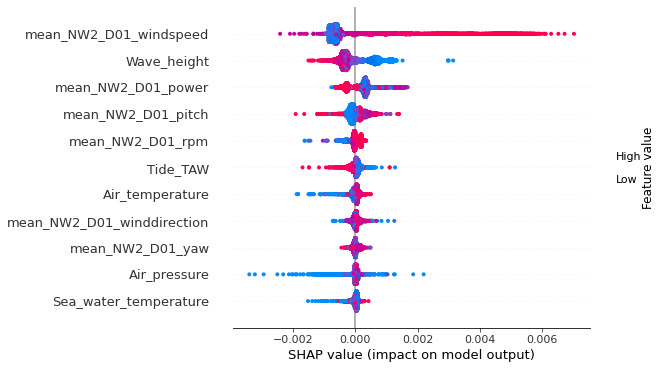

In [11]:
mode = 'SS1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

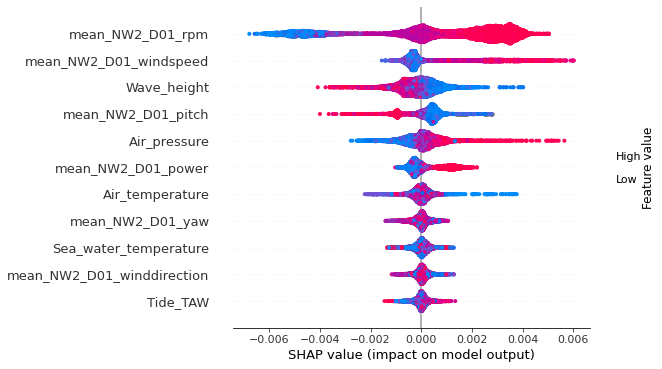

In [8]:
mode = 'FA1'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

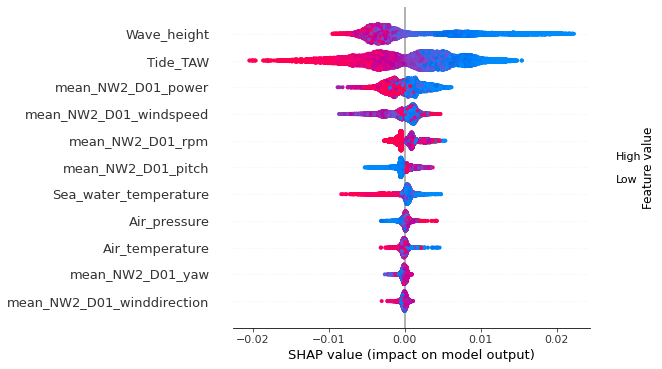

In [9]:
mode = 'SS2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

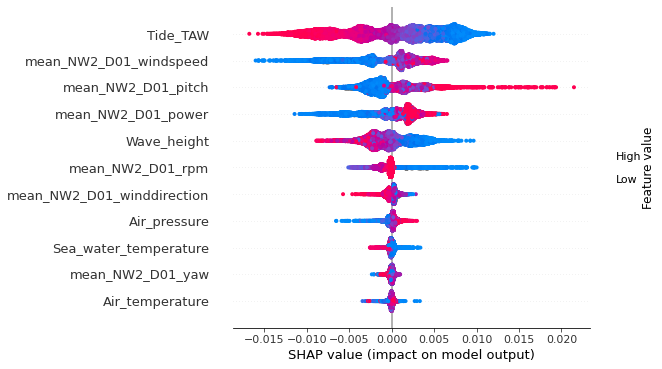

In [10]:
mode = 'FA2'
model = models[mode]
explainers[mode] = shap.Explainer(model)
shap_values[mode] = explainers[mode](inputs)
shap.summary_plot(shap_values[mode], inputs)

SS1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


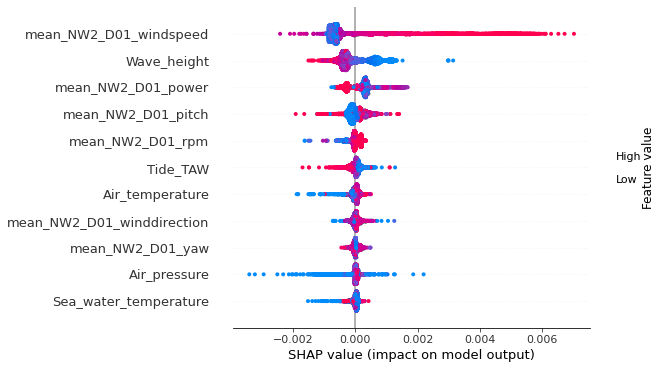

In [6]:
explainers = {}
shap_values = {}
for mode in tracked_frequencies.columns:
    print(mode)
    model = models[mode]
    explainers[mode] = shap.Explainer(model)
    shap_values[mode] = explainers[mode](inputs)
    shap.summary_plot(shap_values[mode], inputs)
    plt.show()